**Projet 6 : Classifiez automatiquement des biens de consommation**

* Consignes : https://openclassrooms.com/fr/projects/631/assignment

**Etude de faisabilité du moteur de classification**

Votre mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

**Contraintes**

Linda vous a communiqué les contraintes suivantes :

* Afin d’extraire les features, mettre en œuvre a minima un algorithme de type SIFT / ORB / SURF.
* Un algorithme de type CNN Transfer Learning peut éventuellement être utilisé en complément, s’il peut apporter un éclairage supplémentaire à la démonstration.


# Chargement et nettoyage

**Imports**

In [568]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv #opencv pour SIFT

pd.options.display.max_rows = 999

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
from keras.preprocessing.image import load_img, img_to_array
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.vgg16 import VGG16

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Activation
from keras.models import clone_model

from ipywidgets import IntProgress
from ipywidgets import Text
from IPython.display import display
from IPython.display import Image

from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL

import time

In [569]:
import os
os.chdir('C:/Users/maido/Desktop/CentralSuplec/P6_segmentation_produit/Flipkart/')

In [570]:
file_path = 'flipkart_com-ecommerce_sample_1050.csv'
data = pd.read_csv(file_path)
data.shape

(1050, 15)

In [571]:
data.sample(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
933,037b39bef3db7ccd264c577a0edf0c0a,2016-01-01 13:15:34 +0000,http://www.flipkart.com/gift-studios-buddha-st...,Gift Studios Buddha Stone Showpiece - 17.6 cm,"[""Home Decor & Festive Needs >> Table Decor & ...",SHIEBTGD4Y65CCNS,1290.0,699.0,037b39bef3db7ccd264c577a0edf0c0a.jpg,False,Buy Gift Studios Buddha Stone Showpiece - 17...,No rating available,No rating available,Gift Studios,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
549,8a15fa23b8c39ac1c7eaac94cbbe6fc6,2016-01-07 05:50:25 +0000,http://www.flipkart.com/hmt-s3648-analog-watch...,HMT S3648 Analog Watch - For Men,"[""Watches >> Wrist Watches >> HMT Wrist Watches""]",WATDYQ93UUZYVFQX,800.0,800.0,8a15fa23b8c39ac1c7eaac94cbbe6fc6.jpg,True,HMT S3648 Analog Watch - For Men - Buy HMT S3...,3.7,3.7,NaN,"{""product_specification""=>[{""key""=>""Mechanism""..."
637,dc0b5ef48b4c132d0651613a9c1e8e40,2016-06-07 14:06:00 +0000,http://www.flipkart.com/fs-mini-klub-printed-b...,FS Mini Klub Printed Baby Boy's Multicolor Bas...,"[""Baby Care >> Infant Wear >> Baby Boys' Cloth...",SRTEJF2S2JDSHJTF,549.0,411.0,dc0b5ef48b4c132d0651613a9c1e8e40.jpg,False,Key Features of FS Mini Klub Printed Baby Boy'...,No rating available,No rating available,FS Mini Klub,"{""product_specification""=>[{""key""=>""Number of ..."


In [572]:
data.isna().sum() # attention à brand 

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

**Nettoyage catégories**

In [573]:
data['product_category_tree'].nunique()

642

In [574]:
# Traitement de categorie (hot encoding ) 3 niveau cat

data['cat_lvl_1']=data["product_category_tree"]
data['cat_lvl_2']=data["product_category_tree"]
data['cat_lvl_3']=data["product_category_tree"]

for i in range(data.shape[0]):
    data['cat_lvl_1'][i] = data["product_category_tree"][i].split('>>')[0].replace('["', "").replace('"]',"").strip()
    data['cat_lvl_2'][i] = data["product_category_tree"][i].split('>>')[1].replace('["', "").replace('"]',"").strip()
    if len(data["product_category_tree"][i].split('>>'))>=3: 
        data['cat_lvl_3'][i] = data["product_category_tree"][i].split('>>')[2].replace('["', "").replace('"]',"").strip()
data.head()


C:\Users\maido\AppData\Local\Temp/ipykernel_17152/3776109714.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cat_lvl_1'][i] = data["product_category_tree"][i].split('>>')[0].replace('["', "").replace('"]',"").strip()
C:\Users\maido\AppData\Local\Temp/ipykernel_17152/3776109714.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cat_lvl_2'][i] = data["product_category_tree"][i].split('>>')[1].replace('["', "").replace('"]',"").strip()
C:\Users\maido\AppData\Local\Temp/ipykernel_17152/3776109714.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,cat_lvl_1,cat_lvl_2,cat_lvl_3
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,Baby Bath Towels
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,Bedsheets
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,Bedsheets


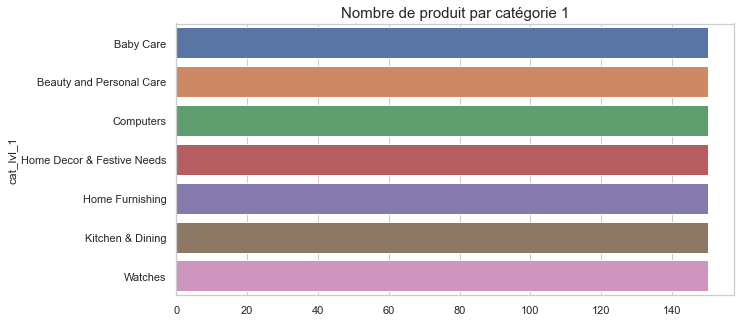

In [391]:
# 150 par produit: catégorie equilibré pour le training 
proportion_nan_ = data.groupby('cat_lvl_1').count()['uniq_id'].sort_values(ascending=False)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.barplot(y = proportion_nan_.index, x=proportion_nan_.values)
plt.title('Nombre de produit par catégorie 1', size=15)
plt.show()

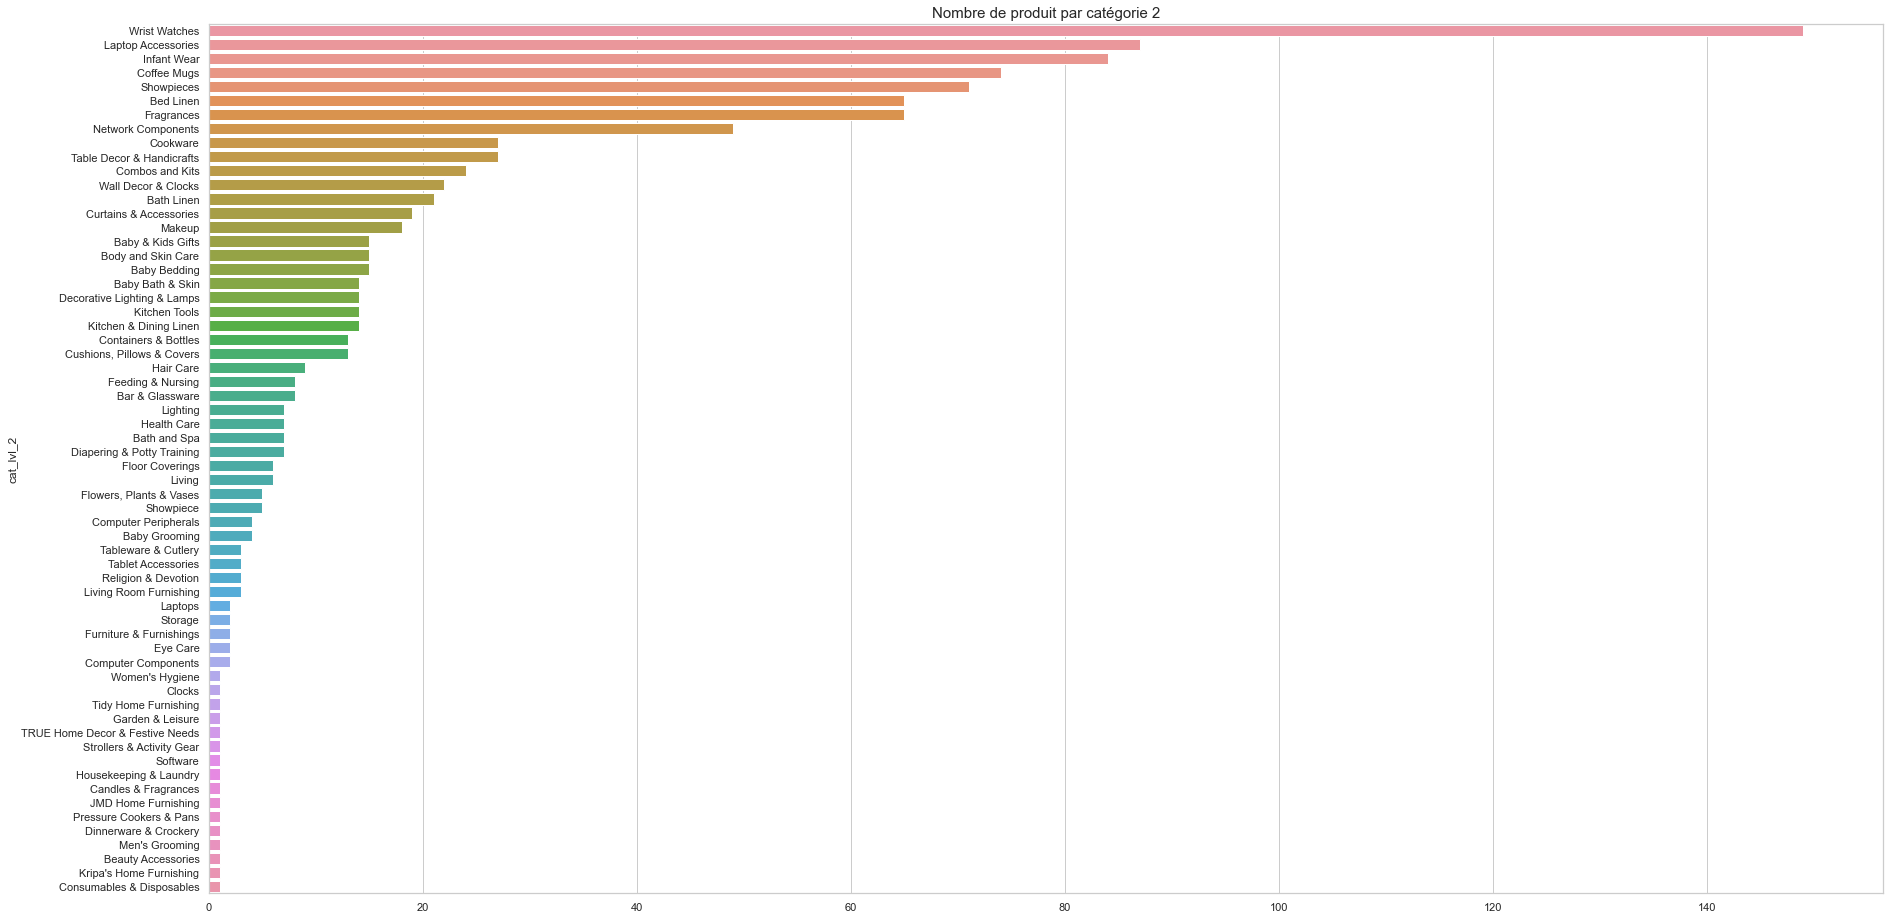

In [67]:
# 150 par produit: catégorie equilibré pour le training 
proportion_nan_ = data.groupby('cat_lvl_2').count()['uniq_id'].sort_values(ascending=False)
sns.set(style="whitegrid")
plt.figure(figsize=(30, 16))
ax = sns.barplot(y = proportion_nan_.index, x=proportion_nan_.values)
plt.title('Nombre de produit par catégorie 2', size=15)
plt.show()

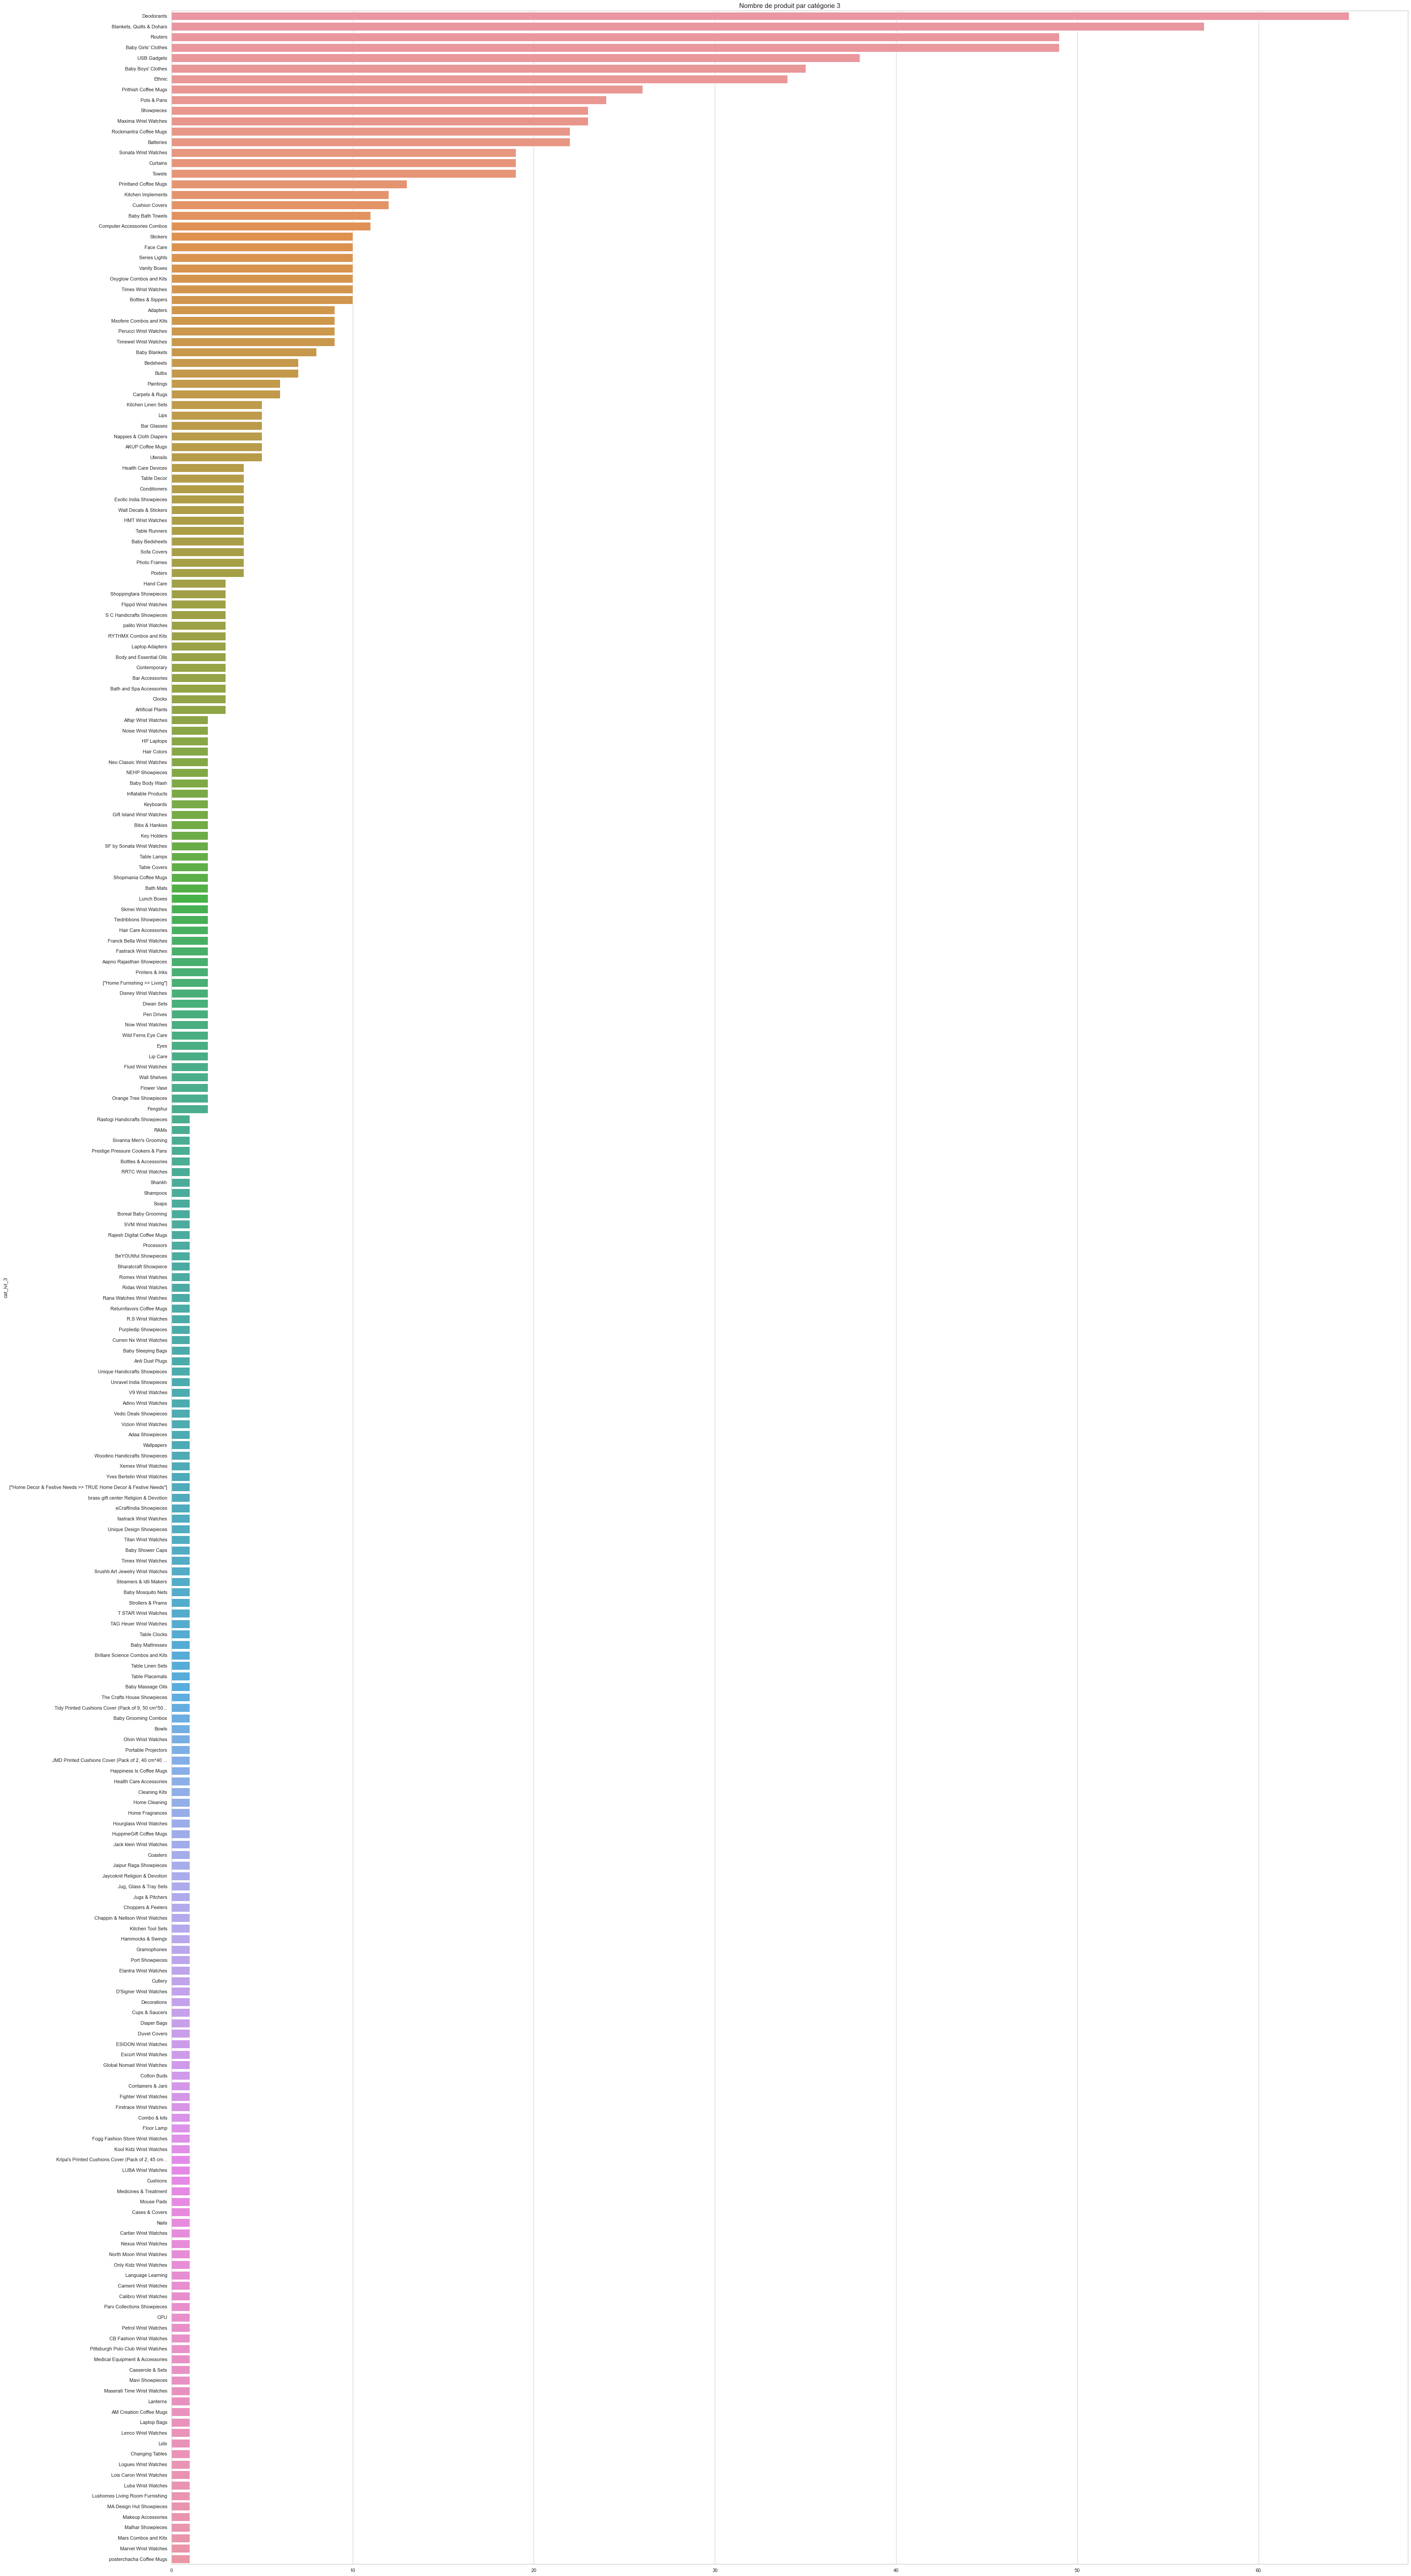

In [76]:
# 150 par produit: catégorie equilibré pour le training 
proportion_nan_ = data.groupby('cat_lvl_3').count()['uniq_id'].sort_values(ascending=False)
sns.set(style="whitegrid")
plt.figure(figsize=(50, 106))
ax = sns.barplot(y = proportion_nan_.index, x=proportion_nan_.values)
plt.title('Nombre de produit par catégorie 3', size=15)
plt.show()

# Préparation des données données textuelles

In [392]:
# tokenization, lemmatizing and removing stop_word using spacy
import spacy 
import nltk 
# Stopwords and single letters
# english_sw = nltk.corpus.stopwords.words('english')
# single_let_sw = list(string.ascii_lowercase)
#sw = list( set(english_sw) )
nlp = spacy.load( "en_core_web_sm", disable=['parser', 'ner'] )
nlp.Defaults.stop_words.add("cm")
nlp.Defaults.stop_words.add("r")

In [393]:
def lemmatize(text): 
    doc = nlp(text) # chargement ??    
    tokens=[ token.lemma_.strip() for token in doc if not (token.is_stop or token.is_punct or token.like_num) ]
    return ' '.join(tokens).lower()
data['description'] = data['description'].apply(lambda x: lemmatize(x).replace("\r\n",""))

In [394]:
data['description'][0]

'key features elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack price r curtain enhance look interior curtain high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic loving curtain ant- wrinkle anti shrinkage elegant apparance home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart thing morning welcome bright sun ray want wish good morning world draw close evening create special moment joyous beauty give soothe print bring home elegant curtain softly filter light room right sunlight ,specifications elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance design door type eyelet model abstract polyester door curtain set model id duster25 color multicolor dimensions length box number contents sales package pack sale package curtains bod

In [395]:
from nltk import Counter
corpus= ' '.join(data["description"])
doc = nlp(corpus)
tokens=[ token.lemma_ for token in doc if not (token.is_stop or token.is_punct or token.like_num) ]
Counter(tokens).most_common(10)

[('product', 863),
 ('free', 618),
 ('buy', 583),
 ('delivery', 567),
 ('genuine', 564),
 ('cash', 564),
 ('price', 561),
 ('replacement', 559),
 ('day', 553),
 ('guarantee', 473)]

In [396]:
pd.DataFrame(np.matrix(Counter(tokens).most_common(10)))

,0,1
0,product,863
1,free,618
2,buy,583
3,delivery,567
4,genuine,564
5,cash,564
6,price,561
7,replacement,559
8,day,553
9,guarantee,473


In [292]:
import matplotlib.pyplot as plt

data.groupby("cat_lvl_1").count()["uniq_id"]
# wordcloud par catégorie
for i in range(7):
    text= ' '.join(data[data["cat_lvl_1"]==data["cat_lvl_1"].unique()[i]]["description"])
    corpus_=lemmatize(text)
    wordcloud = WordCloud(random_state = 8,
        normalize_plurals = False,
        width = 600, height= 300,
        max_words = 100,
        stopwords = [])
##### Apply the wordcloud to the text.
    wordcloud.generate(corpus_)
    fig, ax = plt.subplots(1,1, figsize = (9,6))
# add interpolation = bilinear to smooth things out
    plt.imshow(wordcloud)
# and remove the axis
    plt.axis("off")
    plt.show()

NameError: name 'WordCloud' is not defined

### Vectorisation word embending  

In [590]:
import gensim.downloader as api 
import numpy as np

model = api.load("word2vec-google-news-300")

TypeError: 'KeyedVectors' object is not callable

In [ ]:
model("me")

### Vectorisation TfIdf 

In [423]:
from sklearn.model_selection import train_test_split 
# tester sur echantillon
train, test = train_test_split(data, test_size = 0.25, random_state=42)

In [437]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf= TfidfVectorizer(max_df=0.9, min_df=3 , max_features=1000, stop_words='english')
tfidf.fit(train['description'])

TfidfVectorizer(max_df=0.9, max_features=1000, min_df=3, stop_words='english')

In [438]:
tfidf_vec =tfidf.transform(train['description']) # fit_transfrm
tfidf_vec_ = tfidf.transform(test['description'])

In [439]:
tfidf.get_feature_names()

['175',
 '19',
 '199',
 '3d',
 '499',
 '50',
 '5v',
 '75w',
 '795',
 '799',
 '95a',
 '995',
 '999',
 '9a',
 'able',
 'absorbent',
 'abstract',
 'ac',
 'accessories',
 'accessory',
 'actual',
 'adapter',
 'adaptor',
 'add',
 'addition',
 'additional',
 'adhesive',
 'adidas',
 'adjust',
 'adjustable',
 'adorable',
 'adorn',
 'affordable',
 'age',
 'air',
 'akup',
 'alarm',
 'allow',
 'almond',
 'aloevera',
 'aluminium',
 'analog',
 'angel',
 'ant',
 'anti',
 'antique',
 'antiqueshop',
 'app',
 'appeal',
 'appearance',
 'apple',
 'apply',
 'approx',
 'area',
 'aroma',
 'art',
 'artificial',
 'artisan',
 'artist',
 'artistic',
 'assorted',
 'assure',
 'asus',
 'attention',
 'attitude',
 'attractive',
 'audio',
 'authentication',
 'available',
 'away',
 'baby',
 'bag',
 'bank',
 'banks',
 'base',
 'basic',
 'bath',
 'battery',
 'bazaar',
 'beach',
 'bear',
 'beat',
 'beautiful',
 'beautifully',
 'beauty',
 'bed',
 'bedroom',
 'bedsheet',
 'beige',
 'belt',
 'best',
 'big',
 'birthday',
 'bl

Decomposition en pratique

##  (LDA/NMF)

**NMF (non réutilisé par la suite)**

In [440]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [441]:
matrix_cat= tfidf_vec.todense()

In [442]:
nmf = NMF(n_components = data['cat_lvl_1'].nunique(),
         random_state=1,
         alpha=0.1,
         l1_ratio=0.5).fit(matrix_cat)

C:\Users\maido\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [459]:
nmf.fit(tfidf_vec.todense())

C:\Users\maido\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(alpha=0.1, l1_ratio=0.5, n_components=7, random_state=1)

In [460]:
nmf.get_params()

{'alpha': 0.1,
 'beta_loss': 'frobenius',
 'init': 'warn',
 'l1_ratio': 0.5,
 'max_iter': 200,
 'n_components': 7,
 'random_state': 1,
 'regularization': 'both',
 'shuffle': False,
 'solver': 'cd',
 'tol': 0.0001,
 'verbose': 0}

In [461]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [462]:
tf_feature_names = tfidf.get_feature_names()
print_top_words(nmf, tf_feature_names , n_top_words = 10)

Topic #0: com flipkart combo set guarantee replacement genuine cash shipping delivery
Topic #1: watch analog men india great women discounts rs sonata online
Topic #2: mug ceramic rockmantra coffee perfect gift love safe creation microwave
Topic #3: baby details girl fabric boy cotton neck sleeve dress shirt
Topic #4: showpiece good rs online guarantee replacement day price genuine shipping
Topic #5: abstract single blanket com flipkart quilts comforters genuine shipping cash
Topic #6: warranty laptop inch skin color pack box model features type



In [476]:
def plot_NMF(components):
    # importing libraries
    import matplotlib.pyplot as plt

    # Setting the data to plot
    labels = ['topic_{}'.format(i) for i in range(len(components))]
    frequencies = components

    # Graphical properties of the main figure
    fig = plt.figure(figsize=(14, 6))

    # Main graphical properties of the second subplot (pieplot)
    plt.title("Belonging to topics (NMF)", fontsize=20)

    # plotting the plots
    plt.pie(frequencies,
                autopct='%1.2f%%',
                # shadow=True,
                  )

    plt.legend(labels, loc='upper right', )
    plt.show()
    return fig

In [477]:
matrix= nmf.transform( tfidf.transform(train["description"]).todense() )
matrix.shape

(787, 7)

Sathiyas Cotton Bath Towel


C:\Users\maido\AppData\Local\Temp/ipykernel_17152/3048895309.py:16: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  plt.pie(frequencies,


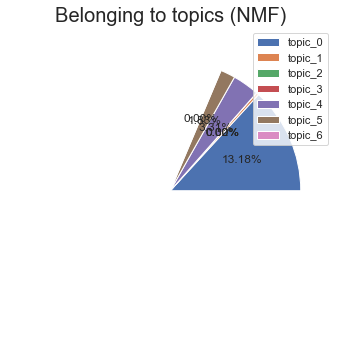

In [478]:
# Belonging to topics for first item
print(data['product_name'].iloc[1])
plot_NMF(  matrix[2,:])
plt.show()

In [480]:
val_best_topic = {} # dict1
best_topic = {} # dict2
matrix = nmf.transform(tfidf.transform(train['description']))
for i in range(0,matrix.shape[0]):
    val_best_topic[i] = 0
    for j in range(0, matrix.shape[1]):
        if matrix[i,j] > val_best_topic[i]:
            val_best_topic[i] = matrix[i,j]
            best_topic[i]= j

In [481]:
train_lda = train.copy()
train_lda['topic_nmf'] = list(best_topic.values())

**Catégories du jeu de données en fonction des topics identifiés**

In [482]:
train_lda[['cat_lvl_1','topic_nmf']].groupby(['topic_nmf','cat_lvl_1']).count() \
            .sort_values(by=['topic_nmf', 'cat_lvl_1'],ascending=[True, False])

Empty DataFrame
Columns: []
Index: [(0, Kitchen & Dining), (0, Home Furnishing), (0, Computers), (0, Beauty and Personal Care), (0, Baby Care), (1, Watches), (1, Beauty and Personal Care), (2, Kitchen & Dining), (2, Home Furnishing), (2, Home Decor & Festive Needs), (2, Baby Care), (3, Home Furnishing), (3, Beauty and Personal Care), (3, Baby Care), (4, Kitchen & Dining), (4, Home Decor & Festive Needs), (4, Computers), (4, Beauty and Personal Care), (4, Baby Care), (5, Home Furnishing), (5, Baby Care), (6, Watches), (6, Kitchen & Dining), (6, Home Furnishing), (6, Home Decor & Festive Needs), (6, Computers), (6, Beauty and Personal Care), (6, Baby Care)]

In [ ]:
val_best_topic = {} # dict1
best_topic = {} # dict2
matrix = lda.transform(tfidf.transform(train['description']))
for i in range(0,matrix.shape[0]):
    val_best_topic[i] = 0
    for j in range(0, matrix.shape[1]):
        if matrix[i,j] > val_best_topic[i]:
            val_best_topic[i] = matrix[i,j]
            best_topic[i]= j

train_lda = train.copy()
train_lda['topic_lda'] = list(best_topic.values())

**Catégories du jeu de données en fonction des topics identifiés**

train_lda[['cat_lvl_1','topic_lda']].groupby(['topic_lda','cat_lvl_1']).count() \
            .sort_values(by=['topic_lda', 'cat_lvl_1'],ascending=[True, False])

**LDA**

In [446]:
lda = LatentDirichletAllocation(n_components = data['cat_lvl_1'].nunique(), random_state=2 )

In [447]:
lda.fit( tfidf.transform(train["description"]).todense() )

LatentDirichletAllocation(n_components=7, random_state=2)

In [448]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

#no_top_words = 10
display_topics(lda , tfidf.get_feature_names(), 10)

Topic 0:
baby cotton pack details girl fabric number general box color
Topic 1:
usb light power warranty adapter glass inch denver rice lights
Topic 2:
showpiece good rs price online guarantee day replacement products genuine
Topic 3:
watch analog men guarantee india replacement rs online day women
Topic 4:
com flipkart genuine cash shipping delivery products free buy guarantee
Topic 5:
mug hair bring ml bottle wall design coffee nutcase gift
Topic 6:
battery rockmantra mug cell ceramic product year craft safe design


On peut distinguer
* topic 1: attribus commercial, produit, livraison. 
* topic 5: Baby Care 
* topic 4: Kitchen & Dining
* topic 6: Home Decor & Festive Needs
* topic 3: watches.

In [449]:
def plot_LDA(components):
    # importing libraries
    import matplotlib.pyplot as plt

    # Setting the data to plot
    labels = ['topic_{}'.format(i) for i in range(len(components))]
    frequencies = components

    # Graphical properties of the main figure
    fig = plt.figure(figsize=(14, 6))

    # Main graphical properties of the second subplot (pieplot)
    plt.title("Belonging to topics (LDA)", fontsize=20)

    # plotting the plots
    plt.pie(frequencies,
                autopct='%1.2f%%',
                # shadow=True,
                  )

    plt.legend(labels, loc='upper right', )
    plt.show()
    return fig

Elegance Polyester Multicolor Abstract Eyelet Door Curtain


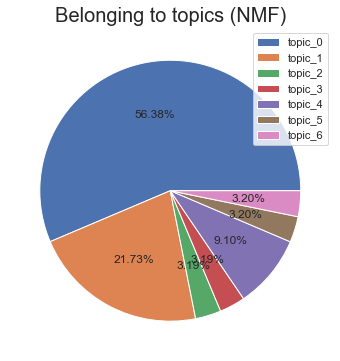

In [479]:
# Belonging to topics for first item
print(data['product_name'].iloc[0])
plot_LDA( lda.transform( matrix_cat)[10,:])
plt.show()

**Topic le plus représenté par catégorie d'article**

In [337]:
val_best_topic = {} # dict1
best_topic = {} # dict2
matrix = lda.transform(tfidf.transform(train['description']))
for i in range(0,matrix.shape[0]):
    val_best_topic[i] = 0
    for j in range(0, matrix.shape[1]):
        if matrix[i,j] > val_best_topic[i]:
            val_best_topic[i] = matrix[i,j]
            best_topic[i]= j

In [338]:
train_lda = train.copy()
train_lda['topic_lda'] = list(best_topic.values())

**Catégories du jeu de données en fonction des topics identifiés**

In [339]:
train_lda[['cat_lvl_1','topic_lda']].groupby(['topic_lda','cat_lvl_1']).count() \
            .sort_values(by=['topic_lda', 'cat_lvl_1'],ascending=[True, False])

Empty DataFrame
Columns: []
Index: [(0, Watches), (0, Kitchen & Dining), (0, Home Furnishing), (0, Home Decor & Festive Needs), (0, Computers), (0, Beauty and Personal Care), (0, Baby Care), (1, Kitchen & Dining), (1, Home Decor & Festive Needs), (1, Computers), (1, Beauty and Personal Care), (1, Baby Care), (2, Watches), (2, Kitchen & Dining), (2, Home Furnishing), (2, Home Decor & Festive Needs), (2, Beauty and Personal Care), (2, Baby Care), (3, Watches), (3, Kitchen & Dining), (3, Home Furnishing), (3, Home Decor & Festive Needs), (3, Computers), (3, Beauty and Personal Care), (3, Baby Care), (4, Kitchen & Dining), (4, Home Furnishing), (4, Home Decor & Festive Needs), (4, Computers), (4, Beauty and Personal Care), (4, Baby Care), (5, Kitchen & Dining), (5, Home Decor & Festive Needs), (5, Beauty and Personal Care), (5, Baby Care), (6, Kitchen & Dining), (6, Home Furnishing), (6, Home Decor & Festive Needs), (6, Computers), (6, Beauty and Personal Care), (6, Baby Care)]

On voit que les topics identifiés sont assez disparates:

* certains semblent assez homogènes avec une catégorie fortement présente: 
    * Topic6: Home Decor & Festive Needs 
    * Topic0: Watches
    * Topic4: Kitchen & Dining, Home Decor & Festive Needs
Le résultat est toutefois assez encourageant vu la faible taille du jeu de données.

**Topic identifiés en fonction des catégories du jeu de données**

In [341]:
train_lda[['cat_lvl_1','topic_lda']].groupby(['cat_lvl_1','topic_lda']).count()

Empty DataFrame
Columns: []
Index: [(Baby Care, 0), (Baby Care, 1), (Baby Care, 2), (Baby Care, 3), (Baby Care, 4), (Baby Care, 5), (Baby Care, 6), (Beauty and Personal Care, 0), (Beauty and Personal Care, 1), (Beauty and Personal Care, 2), (Beauty and Personal Care, 3), (Beauty and Personal Care, 4), (Beauty and Personal Care, 5), (Beauty and Personal Care, 6), (Computers, 0), (Computers, 1), (Computers, 3), (Computers, 4), (Computers, 6), (Home Decor & Festive Needs, 0), (Home Decor & Festive Needs, 1), (Home Decor & Festive Needs, 2), (Home Decor & Festive Needs, 3), (Home Decor & Festive Needs, 4), (Home Decor & Festive Needs, 5), (Home Decor & Festive Needs, 6), (Home Furnishing, 0), (Home Furnishing, 2), (Home Furnishing, 3), (Home Furnishing, 4), (Home Furnishing, 6), (Kitchen & Dining, 0), (Kitchen & Dining, 1), (Kitchen & Dining, 2), (Kitchen & Dining, 3), (Kitchen & Dining, 4), (Kitchen & Dining, 5), (Kitchen & Dining, 6), (Watches, 0), (Watches, 2), (Watches, 3)]

 Les résultats semblent assez hétérogènes avec de nombreuses catégorise représentées

## Classifieurs supervisés sur données textuelles

**Classifieur Multinomial Baive Bayes**

In [121]:
from sklearn.naive_bayes import MultinomialNB
naive_mn = MultinomialNB() # alpha: float, default=1.0. Additive (Laplace/Lidstone) smoothing parameter
naive_mn.fit( tfidf.transform(train["description"]), train["cat_lvl_1"] ) 

MultinomialNB()

In [122]:
from sklearn.metrics import accuracy_score
print('Le score sur l\'échantillon d\'entrainement: {}'
      .format(accuracy_score(naive_mn.predict(tfidf.transform(train["description"]).todense()) , train['cat_lvl_1'])))

Le score sur l'échantillon d'entrainement: 0.8666666666666667


In [123]:
print('Le score sur l\'échantillon de test: {}'
      .format(accuracy_score(naive_mn.predict(tfidf.transform(test["description"]).todense()) , test['cat_lvl_1'] ) ) )

Le score sur l'échantillon de test: 0.68


**Classifier SVC sur jeu de données post LDA**

In [125]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
params2 = {'C' : [0.01, 0.1, 0.5, 0.9, 1, 1.1]}
svc2 = GridSearchCV(SVC(), param_grid = params2, cv=5)

In [126]:
svc2.fit(lda.transform(tfidf.transform(train["description"]).todense()), train['cat_lvl_1'])

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 0.5, 0.9, 1, 1.1]})

In [127]:
print('accuracy sur jeu train:', 
      accuracy_score(svc2.best_estimator_.predict(lda.transform(tfidf.transform(train["description"]).todense())), train['cat_lvl_1']) )

accuracy sur jeu train: 0.52


In [129]:
print('accuracy sur jeu test : ', 
      accuracy_score(svc2.best_estimator_.predict(lda.transform(tfidf.transform(test["description"]).todense())), test['cat_lvl_1']))

accuracy sur jeu test :  0.32


**Classifier Logistic Regression**

In [130]:
from sklearn.linear_model import LogisticRegression

In [131]:
params_lr = {'C' : [0.01, 0.1, 0.5, 0.9, 1, 1.1]} # regulation factor 
lr = GridSearchCV(LogisticRegression(), param_grid = params_lr)
lr.fit(tfidf.transform(train["description"]).todense(), train['cat_lvl_1'])
print('accuracy sur jeu train : ', accuracy_score(lr.best_estimator_.predict(tfidf.transform(train["description"]).todense()), train['cat_lvl_1']))

accuracy sur jeu train :  0.9466666666666667


In [132]:
print('accuracy sur jeu test:', accuracy_score(lr.best_estimator_.predict(tfidf.transform(test["description"]).todense()), test['cat_lvl_1']) )

accuracy sur jeu test: 0.82


**Conclusion sur classification à partir des descriptions**

=> Premiers résultats encourageants sur les classifieurs : 82 % d'accuracy (Regression logistic) sur le jeu de test pour le classifier SVC, le jeu de données complet etant  de seulement 1050 individus

## Classifieurs non supervisés sur données textuelles

**ACP**

In [483]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
# ss_nlp = StandardScaler() # pourquoi le preprocessing ?? pas de variable pour le preprocessing 
X = tfidf.transform(data["description"]).todense()
pca = PCA(n_components =0.9) # quand je suis soulagé 
pca.fit(X)

PCA(n_components=0.9)

In [485]:
X_pca= pca.fit_transform(X)
print('Dimension avant:', X.shape)
print('Dimension après:', X_pca.shape)

Dimension avant: (1050, 1000)
Dimension après: (1050, 257)


In [486]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca')
X_trans = tsne.fit_transform(X_pca)

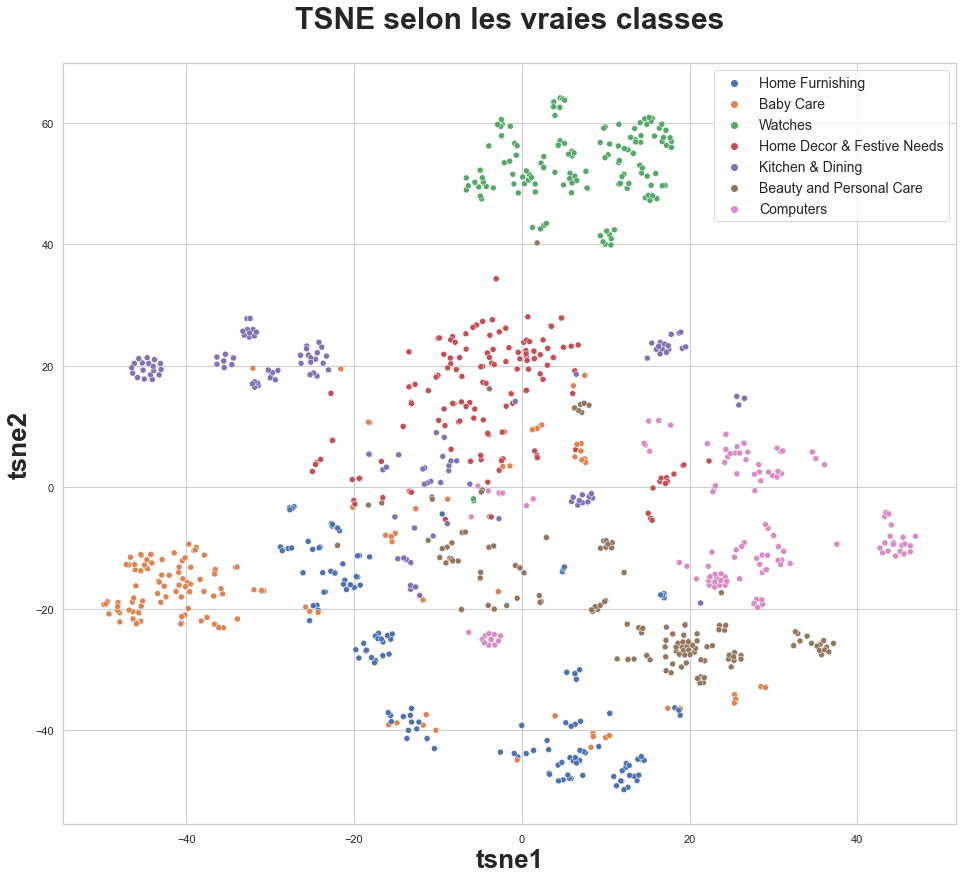

In [488]:
from sklearn import metrics
plt.figure(figsize=(16,14))
sns.scatterplot(x = X_trans[:,0] , y =X_trans[:,1] ,hue=data["cat_lvl_1"] )
plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 
plt.show()

Projection 2D TSNE avant LDA 
* Watches, Kitchen & Dining, Baby Care, Computers et Beauty and Personal Care semblent bien isolé avec quelques interferences.
Home Fournich

In [490]:
# création de 7 clusters à partir du T-SNE 
from sklearn import cluster, metrics 
cls = cluster.KMeans(n_clusters= 7, random_state= 6 ) # modele 
cls.fit(X_trans) # classifier le vec 

data["cluster"]= cls.labels_

In [491]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
data["cat"]= encoder.fit_transform(data["cat_lvl_1"])

###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

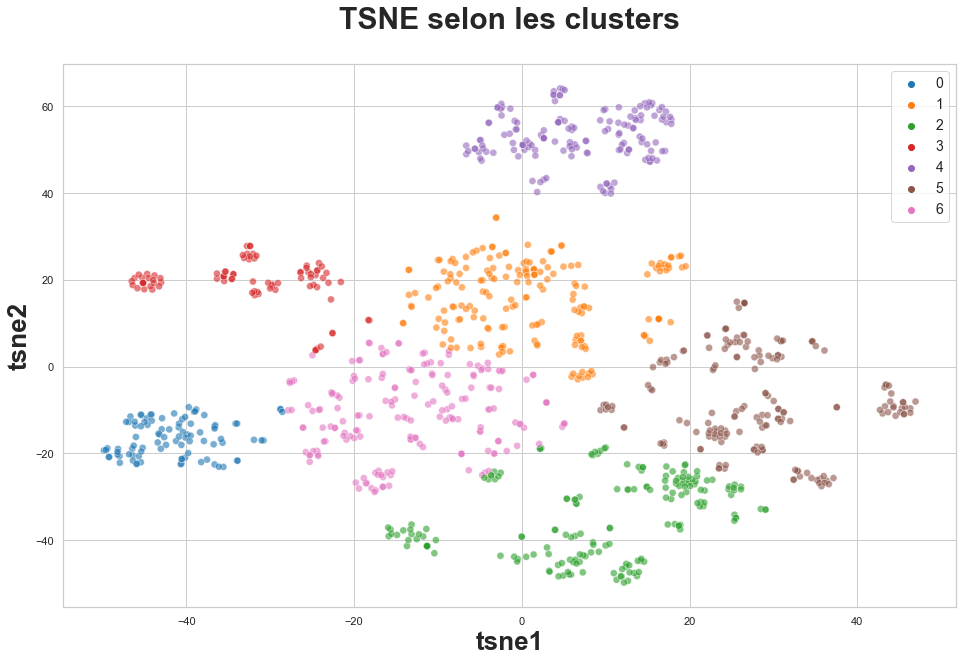

Score ARI: 0.43131304217980876


In [493]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_trans[:,0], y=X_trans[:,1],
    hue=data["cluster"],
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=X_trans,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 
plt.show()
print('Score ARI: {}'.format(metrics.adjusted_rand_score(data["cluster"] , data["cat"]) ))# ARI= 54%  

# Données visuelles

In [575]:
path="C:/Users/maido/Desktop/CentralSuplec/P6_segmentation_produit/Flipkart/Images/"

In [576]:
%matplotlib inline 
from os import listdir
import matplotlib.pyplot as plt 

#list_photos= [file for file in listdir(path)]  

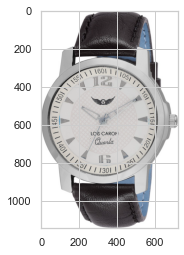

In [579]:
import cv2
img = cv2.imread(path+data["image"].iloc[12] ) 
plt.imshow(np.array(img))

Ensuite, vous analyserez le jeu de données déjà constitué en réalisant un prétraitement des images et des descriptions des produits, une réduction de dimension, puis un clustering. Les résultats du clustering seront présentés sous la forme d’une représentation en deux dimensions à déterminer, qui ’illustrera le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

La représentation graphique vous aidera à convaincre Linda que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.

Attention, Linda n’a pas besoin d’un moteur de classification à ce stade, mais bien d’une étude de faisabilité !


In [580]:
data['image'] = data['image'].apply(lambda x: path+str(x))
data["image"].head()

0    C:/Users/maido/Desktop/CentralSuplec/P6_segmen...
1    C:/Users/maido/Desktop/CentralSuplec/P6_segmen...
2    C:/Users/maido/Desktop/CentralSuplec/P6_segmen...
3    C:/Users/maido/Desktop/CentralSuplec/P6_segmen...
4    C:/Users/maido/Desktop/CentralSuplec/P6_segmen...
Name: image, dtype: object

Home Furnishing


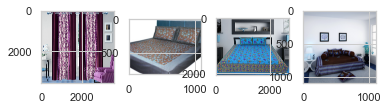

Baby Care


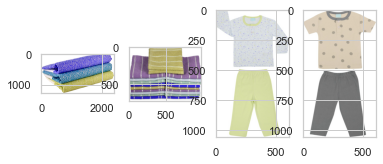

Watches


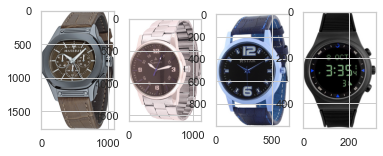

Home Decor & Festive Needs


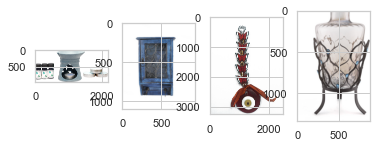

Kitchen & Dining


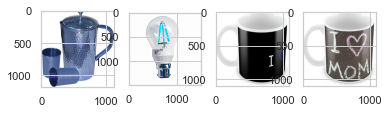

Beauty and Personal Care


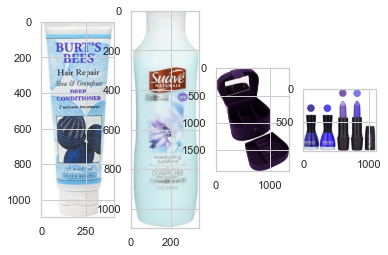

Computers


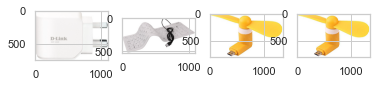

In [582]:
# affichage image par quelques catégories

def list_fct(name): 
    list_img = [data["image"][i] for i in range(len(data["cat_lvl_1"])) if data["cat_lvl_1"][i]==name]
    return list_img

for name in data["cat_lvl_1"].unique()[:7]: 
    print(name)
    for i in  range(4):
        if(data.groupby("cat_lvl_1").count()["uniq_id"][name] ):
            ax1= plt.subplot(141+i)
            img = cv2.imread(list_fct(name)[i])
            plt.imshow(np.array(img))
    plt.show()
#list_fct(name)

### Reduction de bruit (Filtrage Gaussien): 

C:\Users\maido\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


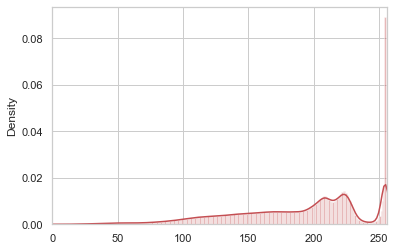

C:\Users\maido\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


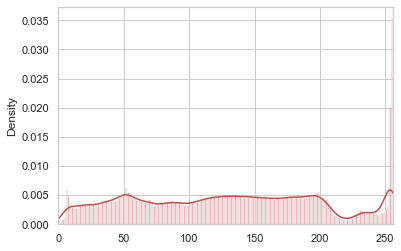

In [602]:
from scipy.ndimage import gaussian_filter #scipy.ndimage for filter 
from PIL import Image as Image_PIL #Pillow for visualizing image 
import cv2

img = cv2.imread(data["image"].iloc[100],0 ) 
im2= cv2.equalizeHist(img)
im2 = gaussian_filter(im2, sigma=3)

plt.figure(figsize=(6,4))
sns.distplot( cv2.imread(data["image"].iloc[100]).flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()

plt.figure(figsize=(6,4))
sns.distplot(im2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()

In [604]:
### Determination et affichage des descripteurs SIFT 
import cv2
sift =cv2.SIFT_create() #methode sift 

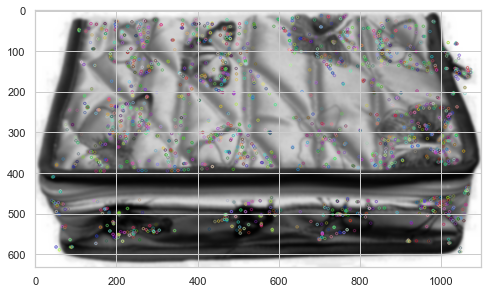

In [609]:
### detecter les descripteur 
plt.figure(figsize=(8,10))
kp, des= sift.detectAndCompute(im2, None ) # orb.detectAndCompute(image_norm, None)
im2= cv2.drawKeypoints(im2, kp, im2)
plt.imshow(im2)
plt.show()

### Prétraitement du data via Sift 
Créations des descripteurs de chaque image:
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [611]:
# alors boucler sur tout les images 
import time ,cv2 
sift_desc=[]   #vect of keypoints 
temps1= time.time()
sift= cv2.SIFT_create() # creation model 

for img_num in range( len(data["image"]) ): 
    if img_num%100 == 0 : print(img_num)
    image = cv2.imread( data["image"][img_num],0 )
    image_norm= cv2.equalizeHist(image)
    im2 = gaussian_filter(image_norm , sigma=3)

    kp, des= sift.detectAndCompute(image_norm, None )
    sift_desc.append(des)

0
100
200
300
400
500
600


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 1498885248 bytes in function 'cv::OutOfMemoryError'


In [ ]:
sift_desc_by_img = np.asarray(sift_desc) # convert as arrray 
sift_desc_all = np.concatenate(sift_desc_by_img, axis=0) # concatenate all 
#sift_desc_by_img

In [ ]:
len(sift_desc) 

Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [121]:
from sklearn import cluster, metrics

# Determination number of clusters 
temps1 = time.time()

k= int( round(np.sqrt(len(sift_desc))) ) 
print("Nombre de clusters estimés : ", k)
print("Création de",k , "clusters de descripteurs ...")

# Clustering 
kmeans = cluster.MiniBatchKMeans(n_clusters= k , init_size = 3*k, random_state=0 )  
kmeans.fit(sift_desc_all)

duration1 = time.time()- temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  32
Création de 32 clusters de descripteurs ...


C:\Users\maido\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


temps de traitement kmeans :          1419.83 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [122]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image: ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des # par exemple si on retrouve 2 fois les cluster 25 hist[i]=2*1/nb_des
    return hist

# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_desc_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc , i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors) # 26 features

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            95.36 secondes


### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [172]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 32)
Dimensions dataset après réduction PCA :  (1050, 24)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [173]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["cat_lvl_1"]
print(df_tsne.shape)

(1050, 3)


In [174]:
df_tsne

,tsne1,tsne2,class
0,-21.279495,-4.142048,Home Furnishing
1,-32.914982,-0.243500,Baby Care
2,-20.803085,-5.017340,Baby Care
3,-16.842459,-19.065058,Home Furnishing
4,-30.795025,3.467184,Home Furnishing
...,...,...,...
1045,-5.918773,-10.562719,Baby Care
1046,11.435872,27.534842,Baby Care
1047,5.250247,-14.016417,Baby Care
1048,-43.897587,-9.386089,Baby Care


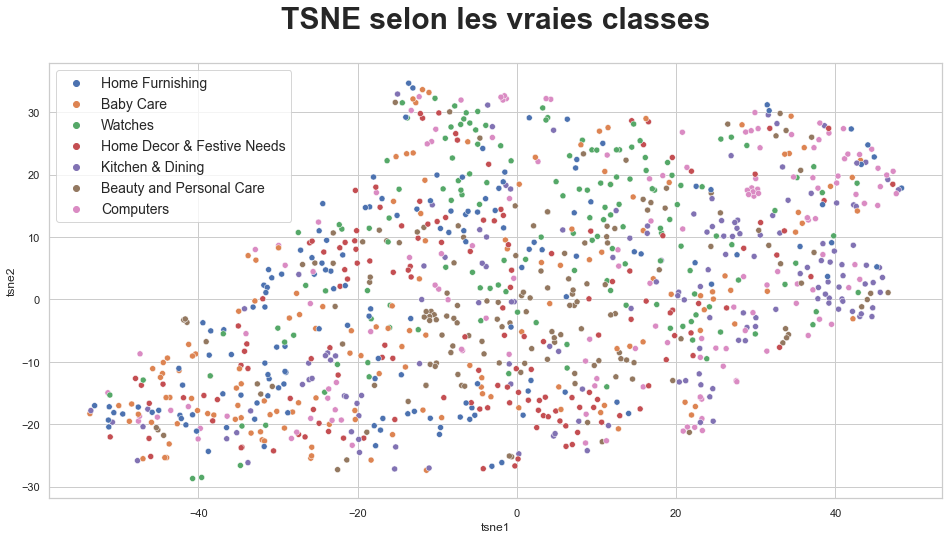

In [176]:
plt.figure(figsize=(16,8))
sns.scatterplot(x = "tsne1" , y ="tsne2" ,hue="class", data= df_tsne )
plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
#plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
#plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 
plt.show()

### Analyse mesures : similarité entre catégories et clusters
#### Création de clusters à partir du T-SNE

In [179]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


In [181]:
# création de 7 clusters à partir du T-SNE 
from sklearn import cluster, metrics 
cls = cluster.KMeans(n_clusters= 7, random_state= 6 ) # modele 
cls.fit(X_tsne) # classifier le vec 

df_tsne["cluster"]= cls.labels_
df_tsne

,tsne1,tsne2,class,cluster
0,-21.279495,-4.142048,Home Furnishing,2
1,-32.914982,-0.243500,Baby Care,2
2,-20.803085,-5.017340,Baby Care,2
3,-16.842459,-19.065058,Home Furnishing,3
4,-30.795025,3.467184,Home Furnishing,2
...,...,...,...,...
1045,-5.918773,-10.562719,Baby Care,3
1046,11.435872,27.534842,Baby Care,1
1047,5.250247,-14.016417,Baby Care,3
1048,-43.897587,-9.386089,Baby Care,5


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 
plt.show()

labels = data["cat"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))


Les résultats Sont peu probant avec un ARI de 4%

In [286]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    138
1    134
2    138
3    171
4    170
5    180
6    119
Name: class, dtype: int64

In [287]:
conf_mat = metrics.confusion_matrix(labels , cls.labels_)
print(conf_mat)

[[16 14 22 17 13 51 17]
 [ 9 26 22 49 16 13 15]
 [18  9 12 12 48 20 31]
 [22 12 24 42 10 27 13]
 [28 15 29 22 13 40  3]
 [12 11 10 18 56 19 24]
 [33 47 19 11 14 10 16]]


In [289]:
def conf_mat_transform(y_true, y_pred): 
    conf_mat = metrics.confusion_matrix(y_true, y_pred )
    corresp = [ 6, 3, 4, 2, 0, 5, 1 ]
    #corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters: ", corresp )
    labels = pd.Series(y_true, name ="y_true").to_frame()
    labels['y_pred']= y_pred
    labels['y_pred_transform']= labels['y_pred'].apply(lambda x: corresp[x])    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters:  [6, 3, 4, 2, 0, 5, 1]
[[13 17 17 14 22 51 16]
 [16 15 49 26 22 13  9]
 [48 31 12  9 12 20 18]
 [10 13 42 12 24 27 22]
 [13  3 22 15 29 40 28]
 [56 24 18 11 10 19 12]
 [14 16 11 47 19 10 33]]

              precision    recall  f1-score   support

           0       0.08      0.09      0.08       150
           1       0.13      0.10      0.11       150
           2       0.07      0.08      0.07       150
           3       0.09      0.08      0.08       150
           4       0.21      0.19      0.20       150
           5       0.11      0.13      0.12       150
           6       0.24      0.22      0.23       150

    accuracy                           0.13      1050
   macro avg       0.13      0.13      0.13      1050
weighted avg       0.13      0.13      0.13      1050



<AxesSubplot:>

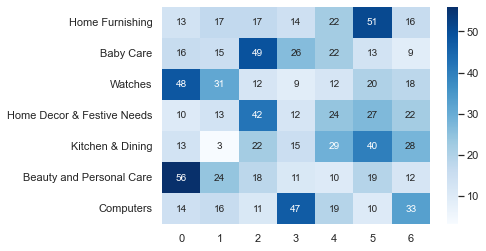

In [300]:
df_cm = pd.DataFrame(conf_mat, index=[label for label in data["cat_lvl_1"].unique()], columns=[i for i in "0123456"] )
plt.figure( figsize=(6,4) )
sns.heatmap(df_cm, annot=True, cmap="Blues")

## CNN Données visuelles

In [612]:
from keras.models import Sequential
from keras.layers import Flatten, Dense 

### VGG16 construit( ImageNet )

In [613]:
from sklearn.model_selection import train_test_split
train, test = train_test_split( data, test_size=0.3, random_state=46)

In [614]:
print('Dimension d\'entrainement:{}'.format(print(train.shape)) )
print('Dimension de test :{}'.format(print(test.shape)) )

(735, 18)
Dimension d'entrainement:None
(315, 18)
Dimension de test :None


#### Prétraitement des image adéquat à VGG16 

In [615]:
from keras.applications.vgg16 import VGG16, preprocess_input 
from keras.preprocessing.image import load_img, img_to_array

model= VGG16() # model vide 
# Nous allons utiliser ce réseau pré-entraîné pour
# classer une image dans une des 1000 catégories d'ImageNet.
img_CNN=[]
for img_file in train['image']:
    img= load_img(img_file , target_size=(224, 224)) # charger l'image 
    img = img_to_array(img)
    img= img.reshape((1, img.shape[0], img.shape[1], img.shape[2])) # tableau de dim 4. 
    img = preprocess_input(img) # meme pretraitement initial du VGG-16
    # concatenate the features_img to features_cnn
    img_CNN.append(img)
train_array_cnn = np.concatenate(img_CNN)

In [616]:
img_CNN=[]
for img_file in test['image']:
    img= load_img(img_file , target_size=(224, 224)) # charger l'image 
    img = img_to_array(img)
    img= img.reshape((1, img.shape[0], img.shape[1], img.shape[2])) # tableau de dim 4. 
    img = preprocess_input(img) # meme pretraitement initial du VGG-16
    # concatenate the features_img to features_cnn
    img_CNN.append(img)
test_array_cnn = np.concatenate(img_CNN)

C:\Users\maido\anaconda3\lib\site-packages\PIL\Image.py:2918: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [102]:
# encoding de cat_level_1 avant entrainement fully_connect VGG-16
from sklearn.preprocessing import OneHotEncoder

ohe= OneHotEncoder() # le modele vide 
array_cats= ohe.fit_transform( np.array(data["cat_lvl_1"]).reshape(-1,1))
#.reshape(-1,1) transformer to colonne

In [127]:
train_array_cats = ohe.transform(train[["cat_lvl_1"]]).todense()
test_array_cats = ohe.transform(test[["cat_lvl_1"]]).todense()

In [128]:
ohe.categories_

[array(['Baby Care', 'Beauty and Personal Care', 'Computers',
        'Home Decor & Festive Needs', 'Home Furnishing',
        'Kitchen & Dining', 'Watches'], dtype=object)]

In [172]:

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(224,224,3,)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(ohe.categories_[0].shape[0], activation='softmax'))
model.compile(loss='mean_squared_error', optimizer='sgd')

In [173]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 7)                

### Entrainement du modéle avec la nouvelle couche fully connected  

In [155]:
print(train_array_cnn.shape)
print(train_array_cats.shape)

(735, 224, 224, 3)
(735, 7)


In [162]:
# Entrainer sur les données d'entrainement
model_info = model.fit(train_array_cnn, train_array_cats, epochs =3, batch_size= 40,  verbose=2)

Epoch 1/3
19/19 - 19s - loss: 1276560146432.0000 - accuracy: 0.1306 - 19s/epoch - 1s/step
Epoch 2/3
19/19 - 15s - loss: 252.7601 - accuracy: 0.1374 - 15s/epoch - 792ms/step
Epoch 3/3
19/19 - 15s - loss: 1.9459 - accuracy: 0.1524 - 15s/epoch - 787ms/step


In [181]:
pred_test= model.predict(test_array_cnn)

In [185]:
from sklearn.metrics import accuracy_score 
accuracy_score(np.argmax(pred_test, axis=1).reshape(-1,1), 
               np.argmax(test_array_cats, axis=1).reshape(-1,1))

0.14603174603174604

precision de 14% meilleurs que les descripteurs sift 

### Transfer Learning VGG16 Imagenet 

In [ ]:
# Suppression et remplacement de la derniere couche VGG16 
from keras.applications.vgg16 import VGG16 
from keras.layers import Dense 
from keras import Model, optimizers 

# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top= False , input_shape= (224, 224, 3) )
# x= model.output
model.layers.pop()
model.layers.pop()
# Récupérer la sortie de ce réseau 
x = model.output

vgg_transfer = Sequential()
vgg_transfer.add(model)
for layer in vgg_transfer.layers:
    layer.trainable = False  

vgg_transfer.add(Flatten()) # applatir le réseau 

# Ajouter la nouvelle couche fully-connected pour la classification à 10 cat 
vgg_transfer.add(Dense(ohe.categories_[0].shape[0], activation ='softmax'))
# ou pour ajouter input et output
#new_model = Model(inputs= model.input , outputs= prediction )
# Compiler le modèle
vgg_transfer.compile(loss="categorical_crossentropy", optimizer='sgd', metrics=["accuracy"])

In [203]:
vgg_transfer.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 7)                 175623    
                                                                 
Total params: 14,890,311
Trainable params: 175,623
Non-trainable params: 14,714,688
_________________________________________________________________


In [205]:
vgg_transfer.fit(train_array_cnn,train_array_cats, epochs=3)

Epoch 1/3
23/23 [==============================] - 176s 7s/step - loss: 162.9023 - accuracy: 0.6531
Epoch 2/3
23/23 [==============================] - 167s 7s/step - loss: 14.6427 - accuracy: 0.9415
Epoch 3/3
23/23 [==============================] - 164s 7s/step - loss: 3.4500 - accuracy: 0.9741


In [206]:
pred = vgg_transfer.predict(test_array_cnn)

In [212]:
accuracy_score(np.argmax(pred, axis=1).reshape(-1,1), 
               np.argmax(test_array_cats, axis=1).reshape(-1,1))

0.8317460317460318

Un résultat très probant de 83% d\'accuracy 